### **Example of retrospective target inference (RTI)**

We 

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]

from plotting_utils import figSize
from simulation import *
import simulation_utils


# for a reproducible result
np.random.seed(1)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from CosineTuning import getAngles
import matplotlib.cm as cm



In [ ]:

base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 20000
base_opts['nUnits']         = 192
base_opts['SNR']            = 0.5
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = False
base_opts['nTrainingSteps'] = 10000

cfg = simulation_utils.initializeBCI(base_opts)


In [ ]:
# Simulate BCI performance with matched neural tuning and decoder, and an optimized gain
import copy
PD_shrinkage = 0.2

results_orig = simulateBCIFitts(cfg)                                                              
print('With a matched, optimized decoder, mean trial time is ', np.mean(results_orig['ttt']), ' s')

# Simulate a change in neural tuning (specifically, change the PDs only, making sure the total magnitude of tuning is the same)
miscal_cfg = copy.deepcopy(cfg)

miscal_cfg['neuralTuning'] = simulation_utils.simulateTuningShift(copy.copy(cfg['neuralTuning']),
                                                                  PD_shrinkage = PD_shrinkage,  )

results_miscal = simulateBCIFitts(miscal_cfg)
print('With changed tuning and a mismatched decoder, the mean trial time is ', np.mean(results_miscal['ttt']), ' s')


Now use RTI to recalibrate

In [4]:
from RTI_utils import RTI

lookback = 70     # look this many timesteps prior to click for training data
minDist  = 0.0    # exclude time points that are too close to target (noisy)
minTime  = 0

rti = RTI(lookback, minDist, minTime)


clickTraj = np.zeros((miscal_cfg['nSimSteps']))
clickTraj[results_miscal['trialStart']] =  1

x, y = rti.label(results_miscal['neuralTraj'], results_miscal['posTraj'], clickTraj)


In [5]:
lr           = LinearRegression(fit_intercept = True).fit(x, y)
cfg_new      = copy.deepcopy(miscal_cfg)
cfg_new['D'] = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_ ]).T 
cfg_new['D'] = simulation_utils.renormalizeDecoder(cfg_new['D'], cfg)
#cfg_new['beta'] = simulation_utils.gainSweep(cfg_new, possibleGain = base_opts['possibleGain'])
    

results_new = simulateBCIFitts(cfg_new)
print('With RTI recalibration, the mean trial time is ', np.mean(results_new['ttt']), ' s')

With RTI recalibration, the mean trial time is  1.2620253164556965  s


/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 41.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


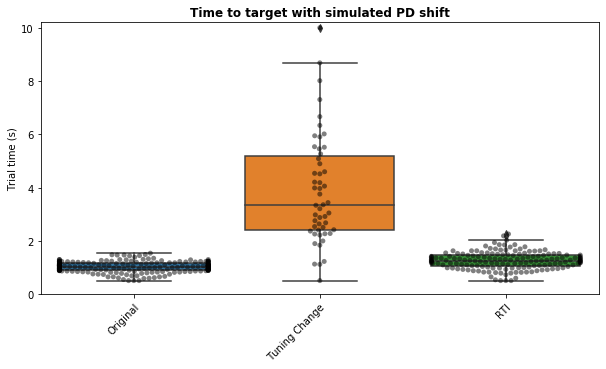

In [9]:
'''
Summarize the performance for all 4 relevant conditions: original performance, performance when the tuning changes (but the decoder
doesn't), performance with the HMM-powered unsupervised recalibration, and performance with supervised recalibration. 
We plot means and 95% CIs.
'''
from scipy.stats import norm
import seaborn as sns


groups = [results_orig['ttt'], results_miscal['ttt'], results_new['ttt']]

figSize(5, 10)
sns.boxplot(data = groups)
sns.swarmplot(data = groups, color = 'k', alpha = 0.5)

ax = plt.gca()
labels = ['Original','Tuning Change', 'RTI']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Trial time (s)')
plt.ylim([0, max([max(i) for i in groups]) + 0.2])
plt.title('Time to target with simulated PD shift', fontweight = 'bold')
plt.show()